# Data visualization with Matplotlib

## Introduction

Mastering data visualization packages such as Matplotlib, Seaborn or Plotly are mandatory skills for a data analyst.
<br>While it is possible to do most of what you need with tools like Tableau, Power BI or Looker, packages such as Matplotlib offer a lot more, in terms of visualizations and of flexibility.

As part of my Football Analytics project, I wanted to showcase some of Matplotlib visualizations and customization features.
<br>Dataset analyzed is related to players and goals from European football championship games, from 2008 to 2016.

## Imports

In [77]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
# from scipy.stats import norm, percentileofscore
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
# import seaborn as sns

# access env. file
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '../'))

## Data preparation

In [37]:
goals_filepath = os.path.join(root_dir, "outputs\Goal events.csv")
shots_filepath = os.path.join(root_dir, "outputs\Shot events.csv")
players_filepath = os.path.join(root_dir, "outputs\Players information.csv")

goals_df = pd.read_csv(goals_filepath)
shots_df = pd.read_csv(shots_filepath)
players_df = pd.read_csv(players_filepath)

### Players

In [38]:
# rounding size to upper unit
players_df["player_height"] = np.round(players_df["player_height"], 0).astype("int64")
players_df = players_df.rename(columns={"player_api_id": "player"})

### All headers (attempts + goals) + player's data

In [39]:
# attempts
temp_df1 = shots_df.copy()
temp_df1 = temp_df1.loc[temp_df1["event_sub_type"].isin(["header", "big chance header", "blocked_header"])]
temp_df1 = temp_df1[["event_id", "event_type", "event_sub_type", "shot_by"]]
temp_df1["type"] = temp_df1["event_type"]
temp_df1 = temp_df1.rename(columns={"shot_by": "player", "event_type": "sub_type"})

# goals
temp_df2 = goals_df.copy()
temp_df2 = temp_df2.loc[temp_df2["event_sub_type"] == "header"]
temp_df2 = temp_df2[["event_id", "event_type", "event_sub_type", "scored_by"]]
temp_df2["type"] = "shoton"
temp_df2 = temp_df2.rename(columns={"scored_by": "player", "event_type": "sub_type"})

# concatenation
header_attempts_and_goals_df = pd.concat([temp_df1, temp_df2])

# fetching player's details
header_attempts_and_goals_df["player"].fillna(0).astype('int64')
header_attempts_and_goals_df = header_attempts_and_goals_df.merge(
    right=players_df,
    on="player",
    how="left"
)

# more cleaning
cols = ["player", "player_height", "player_weight"]
for col in cols:
    header_attempts_and_goals_df[col] = header_attempts_and_goals_df[col].fillna(0).astype('int64')

## 1 - Getting started

With just a few lines of code, it is easy to build visualizations and explore your data!

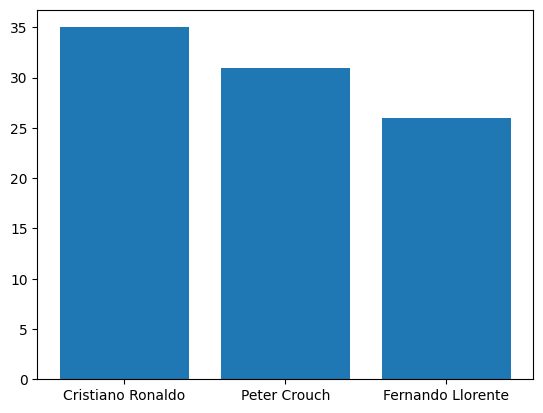

In [52]:
# data prep
top_3_goal_scorers = header_attempts_and_goals_df.loc[header_attempts_and_goals_df["sub_type"] == "goal"]
top_3_goal_scorers = top_3_goal_scorers.groupby(by="player", as_index=False).agg({"player_name": "first", "event_id": "nunique"})
top_3_goal_scorers = top_3_goal_scorers.sort_values(by="event_id", ascending=False).head(3)

# data viz
fig, ax = plt.subplots()
players = top_3_goal_scorers["player_name"]
goals = top_3_goal_scorers["event_id"]
ax.bar(players, goals)
ax.set_ylabel('goals')
ax.set_title('Header goals per player (top 3)')
plt.show()

## 2 - Limitations with basic visualizations

The above example was very straightforward, with 3 data points (3 players) to display on a bar chart.
<br>With more complex visualizations or more data points, the result may be a bit disappointing.
<br>More lines of code will be required to customize the charts.

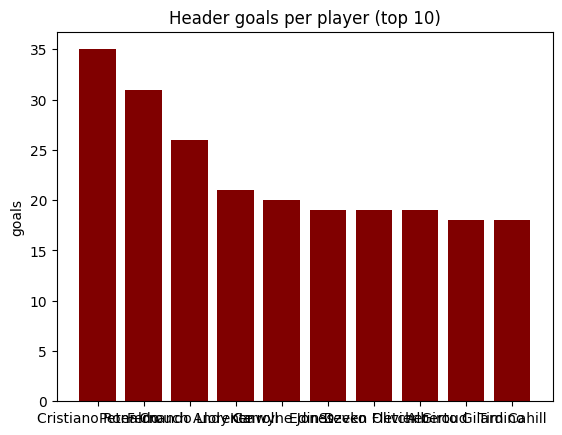

In [51]:
# data prep
top_10_goal_scorers = header_attempts_and_goals_df.loc[header_attempts_and_goals_df["sub_type"] == "goal"]
top_10_goal_scorers = top_10_goal_scorers.groupby(by="player", as_index=False).agg({"player_name": "first", "event_id": "nunique"})
top_10_goal_scorers = top_10_goal_scorers.sort_values(by="event_id", ascending=False).head(10)

# data viz
fig, ax = plt.subplots()
players = top_10_goal_scorers["player_name"]
goals = top_10_goal_scorers["event_id"]
ax.bar(players, goals, color="#800000")
ax.set_ylabel('goals')
ax.set_title('Header goals per player (top 10)')
plt.show()

## 3 - Customization

Below are some examples of how to customize your matplotlib visualizations for more readable, more efficient visualizations.

### A - Labels

1) each artist / bar of the chart coordinates must be fetched (bar.get_x(), bar.get_y())
2) each artist dimensions must be fetched (bar.get_width(), bar.get_height())
3) a legend is plot with the function ax.text()
4) each label is positioned with dedicated coordinates
    - x coordinate will be it's x position + it's width divided by 2 (so that it is centered)
    - y coordinate will be it's height, to which you can add +1 / +2 (to be slightly above bar)

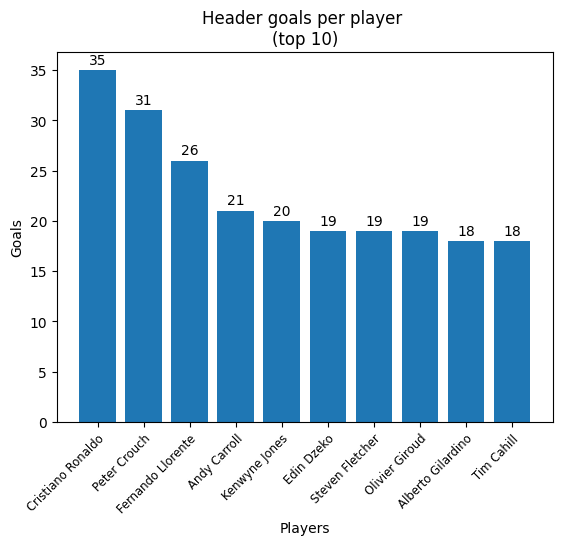

In [75]:
# data viz
players = top_10_goal_scorers["player_name"]
goals = top_10_goal_scorers["event_id"]

# creating a single figure with 1 "plot container" (axes)
fig, ax = plt.subplots()

# creating bars
bars = ax.bar(players, goals)

# adding title, x and y labels
ax.set_title("Header goals per player \n(top 10)") # \n for line return
ax.set_ylabel("Goals")
ax.set_xlabel("Players")

# adding bar labels
for bar, value in zip(bars, goals):
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height() + 1,
        s=value,
        ha="center",
        va="center",
        color="black"
    )

# 45 degree rotation, using both horizontal alignment and rotation mode for best readability
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize="small")

plt.show()

### B - Color gradients

1) Purpose is to use the "alpha" parameter, or transparency parameter, ranging from 0 (transparent) to 1 (opaque)
2) Key is to normalize values (min-max scaling from 0 to 1) of your chart (value / max value of the chart)

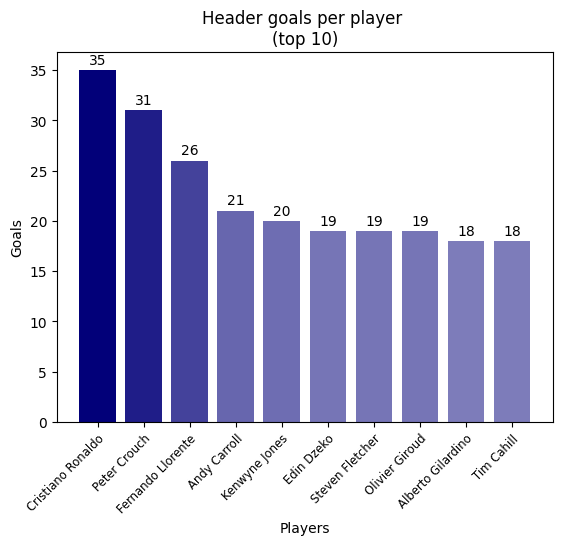

In [54]:
# data viz

players = top_10_goal_scorers["player_name"]
goals = top_10_goal_scorers["event_id"]

# adding a color gradient
# this is done by normalizing the data on a 0-1 scale (where 0 is the min value, 1 the max number of goals)
normalized_goals = np.array(goals) / max(goals)
colors = [("#020079", alpha) for alpha in normalized_goals]

# creating a single figure with 1 "plot container" (axes)
fig, ax = plt.subplots()

# creating bars
bars = ax.bar(players, goals, color=colors)

# adding bar labels
for bar, value in zip(bars, goals):
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height() + 1,
        s=value,
        ha="center",
        va="center",
        color="black"
    )

# adding title, x and y labels
ax.set_title("Header goals per player \n(top 10)") # \n for line return
ax.set_ylabel("Goals")
ax.set_xlabel("Players")

# 45 degree rotation, using both horizontal alignment and rotation mode for best readability
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize="small")

plt.show()

### C - Legend

A legend is an artist made of handles, which are "legend items".
Each handle contains a color patch and a label.

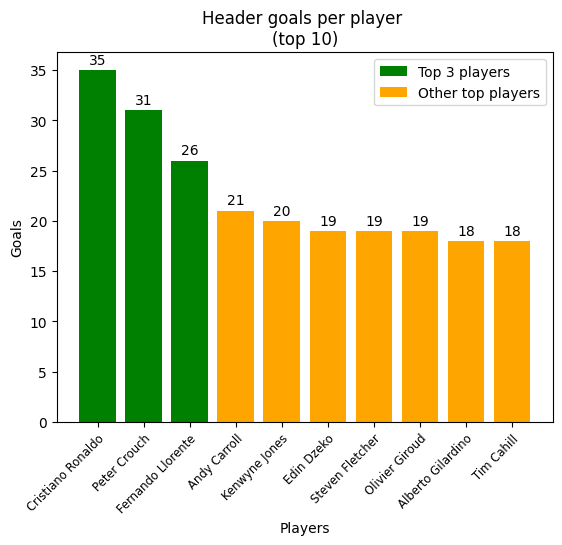

In [78]:
# data viz

players = top_10_goal_scorers["player_name"]
goals = top_10_goal_scorers["event_id"]

# adding a color based on the values: top 3 players are in green, other players are in orange
colors = ["green" if i < 3 else "orange" for i in range(len(top_10_goal_scorers))]

# adding handles
handles = [
    mpatches.Patch(facecolor="green", label="Top 3 players"),
    mpatches.Patch(facecolor="orange", label="Other top players")
]

# creating a single figure with 1 "plot container" (axes)
fig, ax = plt.subplots()

# creating bars
bars = ax.bar(players, goals, color=colors)

# legend
plt.legend(handles=handles)

# adding bar labels
for bar, value in zip(bars, goals):
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height() + 1,
        s=value,
        ha="center",
        va="center",
        color="black"
    )

# adding title, x and y labels
ax.set_title("Header goals per player \n(top 10)") # \n for line return
ax.set_ylabel("Goals")
ax.set_xlabel("Players")

# 45 degree rotation, using both horizontal alignment and rotation mode for best readability
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize="small")

plt.show()

### A - How tall are European Football players?

The below chart indicates the median to be 183 cm. 
<br>In other words, half of all players are shorter than 183 cm, the other half are taller than 183 cm.
<br>The 95% confidence interval means 95% of all football players are within a defined range, of 170cm to approx. 193 cm.

In [ ]:
# data prep

players_height_sorted = pd.Series(players_df["player_height"])
players_height_sorted = np.sort(players_height_sorted)

players_height_mean = np.mean(players_height_sorted)
players_height_std_dev = np.std(players_height_sorted)

In [ ]:
# plotting

plt.figure(figsize=(8, 6))

plt.plot(
    players_height_sorted, 
    norm.pdf(players_height_sorted, players_height_mean, players_height_std_dev), 
    color="green", 
    label="KDE",
    fillstyle="none"
)

# plotting values for labels
players_height_q2 = np.percentile(players_height_sorted, 50)

# drawing 95% confidence interval
percentiles = np.percentile(players_height_sorted, [2.5, 97.5])
for percentile in percentiles:
    plt.axvline(percentile, color="red", linestyle="-", linewidth=1)

# median line and label
plt.axvline(players_height_q2, color='purple', linestyle='--', linewidth=1)
plt.text(players_height_q2, plt.ylim()[1]*0.1,color='purple', s=f"Median: {players_height_q2:.2f}")

# chart labels and axis
plt.title('Normal Distribution with 95% Confidence Interval')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

### B - Are BBC players considered tall?

<br> Benzema is at median level, so he is taller than 50% of all the european players.
<br> Bale is at taller than 70% of all european players.
<br> Ronaldo is at taller than 76% of all european players.

All three players are on the taller end of the european footballer spectrum.
<br>That being said, player's size doesn't vary much and the difference with most players, in cm, is not very significant.
<br>Only 2 centimeters separate Q2 from Q3.

In [ ]:
# percentile for each of the BBC players

players_dict = {
    "Benzema": 183,
    "Bale": 185,
    "Ronaldo": 187
}

for key, value in players_dict.items():
    player_rank = percentileofscore(players_height_sorted, value, kind="mean")
    print(f"{key} ranks in the {player_rank:.0f}th percentile")

### C - How many attempts and goals are we analyzing?

We are analyzing over 30k attempts, with 10k on target and 4k goals.

There are different kind of goals. While we care about headers, let's have a quick overview of all goals.
<br>Always have an eye on the quality of your data. Here, I can spot (in red), a few anomalies.
<br>Unfortunately, I do not have any documentation related to my data set to explain these so I will only disregard these.

Lots of header goals scored. 1550 for our analysis. This should be enough for significant findings.

In [ ]:
# data prep

agg_header_attempts_goals_df = header_attempts_and_goals_df.groupby(by="sub_type").agg({"event_id": "count"}).reset_index()
agg_header_attempts_goals_df = agg_header_attempts_goals_df.sort_values(by="event_id", ascending=False)

In [ ]:
# plotting

fig, ax = plt.subplots()
categories = agg_header_attempts_goals_df["sub_type"]
values = agg_header_attempts_goals_df["event_id"]
bars = ax.barh(categories, values)

# labels and title
for bar, value in zip(bars, values):
    ax.text(value, bar.get_y() + bar.get_height() / 2, str(value),
            va='center', ha='left', color='black')

ax.set_xlabel("Number of events")
ax.set_ylabel("Event type")
ax.set_title("Attempts per event type (goal, shot on, shot off)")

# descending order
ax.invert_yaxis()

plt.show()

### D - Which players stand out?

Some players stand out among all of them.
<br>Let's have a look at the players who attempt the most, then who score the most, then let's analyze the two together.
<br>Most of the top header goal scorers are also among the players who attempt the most (highlighted in red).

<br>To rank players based on both attempts and goals, we will apply a weighted ranking. Goals will account for 75% of the rank, attempts for 25%.

In [ ]:
# data prep

# attempts per player
attempts_per_player = header_attempts_and_goals_df.groupby(by="player_name", as_index=False).agg({"event_id": "count"})
attempts_per_player = attempts_per_player.sort_values(by="event_id", ascending=False)
attempts_per_top_ten_player = attempts_per_player.head(10)

# goals per player
goals_per_player = header_attempts_and_goals_df.loc[header_attempts_and_goals_df["sub_type"] == "goal"]
goals_per_player = goals_per_player.groupby(by="player_name", as_index=False).agg({"event_id": "count"})
goals_per_player = goals_per_player.sort_values(by="event_id", ascending=False)
goals_per_top_ten_player = goals_per_player.head(10)

# players in both top 10s
top_10_header_attempters = attempts_per_top_ten_player["player_name"].to_list()
top_10_header_scorers = goals_per_top_ten_player["player_name"].to_list()
players_in_both_tops = [item for item in top_10_header_attempters if item in top_10_header_scorers]

In [ ]:
players_in_both_tops

In [ ]:
# styling

players_in_both_top_colors = 'green'
default_color = 'blue'
colors1 = [players_in_both_top_colors if category in players_in_both_tops else default_color for category in attempts_per_player["player_name"]]
colors2 = [players_in_both_top_colors if category in players_in_both_tops else default_color for category in goals_per_player["player_name"]]

In [ ]:
# plotting

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

categories = attempts_per_top_ten_player["player_name"]
values = attempts_per_top_ten_player["event_id"]
bars = axes[0].barh(categories, values, color=colors1)

# labels and title
for bar, value in zip(bars, values):
    axes[0].text(value, bar.get_y() + bar.get_height() / 2, str(value),
            va='center', ha='left', color='black')

axes[0].set_xlabel("Number of attempts")
axes[0].set_ylabel("Player")
axes[0].set_title("Top 10 players in terms of header attempts")

# descending order
axes[0].invert_yaxis()

categories = goals_per_top_ten_player["player_name"]
values = goals_per_top_ten_player["event_id"]
bars = axes[1].barh(categories, values, color=colors2)

# labels and title
for bar, value in zip(bars, values):
    axes[1].text(value, bar.get_y() + bar.get_height() / 2, str(value),
            va='center', ha='left', color='black')

axes[1].set_xlabel("Number of goals")
axes[1].set_ylabel("Player")
axes[1].set_title("Top 10 players in terms of header goals")

# descending order
axes[1].invert_yaxis()

# adjusts padding between / around subplots
plt.tight_layout()

In [ ]:
# data prep

attempts_goals_per_player = pd.merge(goals_per_player, attempts_per_player, on="player_name", how="left")
attempts_goals_per_player = attempts_goals_per_player.rename(columns={"event_id_x": "goals", "event_id_y": "attempts"})
attempts_goals_per_player["attempts"] = attempts_goals_per_player["attempts"].fillna(0).astype("int64")
attempts_goals_per_player["goals"] = attempts_goals_per_player["goals"].fillna(0).astype("int64")
attempts_goals_per_player["weighted_score"] = (0.75 * attempts_goals_per_player["goals"]) + (0.25 * attempts_goals_per_player["attempts"])
attempts_goals_per_player = attempts_goals_per_player.sort_values(by="weighted_score", ascending=False)

In [ ]:
# plotting

fig, ax = plt.subplots(figsize=(8, 8))

top_10_header_attempts_goals_players = attempts_goals_per_player["player_name"].head(5).unique()
colors3 = ["red" if player in top_10_header_attempts_goals_players else "blue" for player in attempts_goals_per_player["player_name"]]

for row, data in enumerate(attempts_goals_per_player.iterrows(), start=0):
    if attempts_goals_per_player["player_name"][row] in top_10_header_attempts_goals_players:
        plt.text(attempts_goals_per_player["attempts"][row], attempts_goals_per_player["goals"][row], attempts_goals_per_player["player_name"][row], fontsize=8, ha='right')

plt.scatter(attempts_goals_per_player["attempts"], attempts_goals_per_player["goals"], alpha=0.5, c=colors3)

ax.set_xlabel("Number of attempts")
ax.set_ylabel("Number of goals")
ax.set_title("Attempts vs goals per player")

plt.show()

In [ ]:
all_header_goals_df = header_attempts_and_goals_df.copy()
# all_header_goals_df = all_header_goals_df.loc[all_header_goals_df["sub_type"] == "goal"]

In [ ]:
all_header_goals_df = all_header_goals_df.groupby(by="player", as_index=False).agg(
    goals=pd.NamedAgg(column="sub_type", aggfunc=lambda x: (x == "goal").sum()),
    attempts=pd.NamedAgg(column="sub_type", aggfunc=lambda x: (x.isin(["shoton", "shotoff"])).count()),
    player_height=pd.NamedAgg(column="player_height", aggfunc="min")
)

all_header_goals_df = all_header_goals_df.loc[all_header_goals_df["player_height"] != 0]

# all_header_goals_df = all_header_goals_df.groupby(by="player_height", as_index=False).agg({"goals": "sum", "player": "nunique"})

# all_header_goals_df = all_header_goals_df.sort_values(by="player_height", ascending=True)

In [ ]:
df = all_header_goals_df.copy()

In [ ]:
df["conversion_rate"] = df["goals"] / df["attempts"]

In [ ]:
df

In [ ]:
s1 = df["goals"]
s2 = df["player_height"]

s1.corr(s2)

In [ ]:
s1 = df["goals"]
s2 = df["player_height"]

s1.corr(s2)

In [ ]:
# from sklearn.cluster import KMeans

# # Clustering (k-means)
# kmeans = KMeans(n_clusters=3)

# attempts_per_player['cluster_group'] = kmeans.fit_predict(attempts_per_player[['event_id']])

In [ ]:
# attempts_per_player["cluster_group"].value_counts()

In [ ]:
# goals_per_type = header_attempts_and_goals_df.groupby(by="event_sub_type").agg({"event_id": "count"}).reset_index()
# goals_per_type = goals_per_type.sort_values(by="event_id", ascending=True)

In [ ]:
# # aggregation per goal type + sort values in descending order
# goals_per_type = goal_types_per_player.groupby(by="event_sub_type").agg({"event_id": "count"}).reset_index()
# goals_per_type = goals_per_type.sort_values(by="event_id", ascending=True)

In [ ]:
# # flagging DQ issues with another color
# data_quality_issues = ["saved_back_into_play", "saved", "missed", "post"]
# dq_issues_color = 'red'
# default_color = 'blue'
# colors = [dq_issues_color if category in data_quality_issues else default_color for category in goals_per_type["event_sub_type"]]

# # plotting
# fig, ax = plt.subplots()
# categories = goals_per_type["event_sub_type"]
# values = goals_per_type["event_id"]
# bars = ax.barh(goals_per_type["event_sub_type"], goals_per_type["event_id"], color=colors)

# # labels and title
# for bar, value in zip(bars, values):
#     ax.text(value, bar.get_y() + bar.get_height() / 2, str(value),
#             va='center', ha='left', color='black')

# ax.set_xlabel("Number of goals")
# ax.set_ylabel("Goal type")
# ax.set_title("Number of goals per goal type")

# plt.show()

## D - How many header attempts (on and off target) are we analyzing?

We are analyzing over 27k header attempts. 28.5k if we add the header goals scored.

For 3 header attempts, 2 are off target and 1 is on target.

In [ ]:
# filtering on headers
header_type = ["header", "big chance header", "blocked_header"]

header_attempts_df = shots_df.copy()
header_attempts_df = header_attempts_df.loc[header_attempts_df["event_sub_type"].isin(header_type)]
header_attempts_df = header_attempts_df.groupby(by="event_type", as_index=False).agg({"event_id":"count"})

In [ ]:
# plotting all shots
header_shots_data = pd.Series(header_attempts_df["event_id"])
header_shots_labels = pd.Series(header_attempts_df["event_type"])

plt.pie(header_shots_data, labels=header_shots_labels, autopct="%1.1f%%")
plt.legend(loc="upper right")
plt.show()

## Step 3 - Relationship between tall players and header goals

### A - Overview of goals per player's height

Looking at the below chart, we notice the number of goals per player's height.
<br>There seems to be some kind of relationship between tall players and header goals. Lots of these goals are scored by players over approx. 185 cm.

In [ ]:
# filtering on header goals
headers_and_player_height = goal_types_per_player.loc[goal_types_per_player["event_sub_type"] == "header"]

plt.scatter(headers_and_player_height["player_height"], headers_and_player_height["event_id"], alpha=0.5)

# median player's height for reference
players_height_q2 = np.percentile(players_height_sorted, 50)
plt.axvline(players_height_q2, color='purple', linestyle='--', linewidth=1, label=f"Q2: {players_height_q2:.2f}")
plt.text(players_height_q2, plt.ylim()[1]*0.9,color='purple', s=f"Median: {players_height_q2:.2f}")

# adding labels
plt.title('Number of header goals scored per player\'s height')
plt.xlabel('Height (cm)')
plt.ylabel('Number of goals')
plt.show()

### B - Correlation between a player's height and header goals

Beware of selection bias: 
- extremely tall players (e.g. over 2m) are rare, so it is not abnormal to find few goals scored by very tall players
- the question is rather: for a given height, in cm, how many players are there and how many goals are scored
- correlation should be computed accordingly

In [ ]:
shots_df.dtypes

In [ ]:
all_headers = shots_df.copy()

# filling NA values with a 0 and making it int type
all_headers["shot_by"] = all_headers["shot_by"].fillna(0).astype('int64')

all_headers = all_headers.loc[all_headers["event_sub_type"] == "header"]

# aggregation at goal type and scorer levels
all_headers_per_player = all_headers.groupby(
        by=["event_sub_type", "shot_by"], 
        as_index=False,
        dropna=False
    )["event_id"].nunique().sort_values(by="event_id", ascending=False)

all_headers_per_player = all_headers_per_player.merge(
    right=all_players_df,
    left_on="shot_by",
    right_on="player_api_id",
    how="left"
)

all_headers_per_player = all_headers_per_player.dropna()


In [ ]:
headers_and_player_height = headers_and_player_height.loc[
    (~headers_and_player_height["player_height"].isna())
    ]

headers_and_player_height["player_height"] = np.round(headers_and_player_height["player_height"]).astype(int)

headers_and_player_height = headers_and_player_height[["event_id", "player_height"]]

headers_and_player_height["event_id"].sum()

In [ ]:
# copy of goal_df
header_goals = goal_df.loc[
    goal_df["event_sub_type"] == "header"
    ]

header_goals["scored_by"] = header_goals["scored_by"].fillna(0).astype('int64')

header_goals = header_goals.merge(
    right=all_players_df,dd
    left_on="scored_by",
    right_on="player_api_id",
    how="left"
)

header_goals = header_goals.loc[
    ~header_goals["player_height"].isna()
    ]

header_goals["player_height"] = header_goals["player_height"].astype(int)

In [ ]:
# copy of goal_df
header_goals = goal_df.loc[
    goal_df["event_sub_type"] == "header"
    ]

header_goals["scored_by"] = header_goals["scored_by"].fillna(0).astype('int64')

header_goals = header_goals.merge(
    right=all_players_df,
    left_on="scored_by",
    right_on="player_api_id",
    how="left"
)

header_goals = header_goals.loc[
    ~header_goals["player_height"].isna()
    ]

header_goals["player_height"] = header_goals["player_height"].astype(int)

In [ ]:
header_goals = header_goals.groupby(by="player_height", as_index=False)["event_id"].nunique().sort_values(by="player_height", ascending=True)

In [ ]:
s1 = players_and_goals_by_height["player_height"]
s2 = players_and_goals_by_height["event_id"]

s1.corr(s2)

In [ ]:
correlation_df = players_by_height.merge(
    right=header_goals,
    on="player_height",
    how="left"
)

In [ ]:
s1 = correlation_df["player_api_id"]
s2 = correlation_df["event_id"]

s1.corr(s2)